## Convolutional Layer

In [1]:
%run './init.py'
%matplotlib inline

Neurons in the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields (filters). This rule is repeated in the subsequent convolutional layers. As the result, the network will concentrate on low-level features in the first hidden layer, then assemble (combine) theme into higher-level features in the next hidden layers.

Mathematical Formulas
(update later...)

In [2]:
from sklearn.datasets import load_sample_image

# Return images as a 3D numpy array (height x width x color)
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")

In [3]:
flower.shape

(427, 640, 3)

In [4]:
flower.size

819840

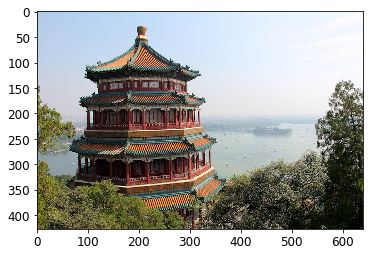

In [5]:
plot_image(china)

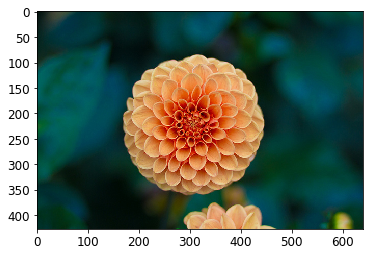

In [6]:
plot_image(flower)

Height:70  Width:120  Channels:3


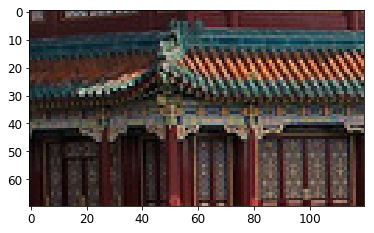

In [7]:
image = china[150:220, 130:250]
height, width, channels = image.shape
print("Height:{}  Width:{}  Channels:{}".format(height, width, channels))
plot_image(image)

In [8]:
# https://goo.gl/BZ2DJN
# Simple grayscale conversion using (R + G + B) / 3
image_grayscale = image.mean(axis=2).astype(np.float32)

# Create 4-D input in the form of [batch, height, width, channels]
# which will be used by the convolution operation later
images = image_grayscale.reshape(1, height, width, 1)

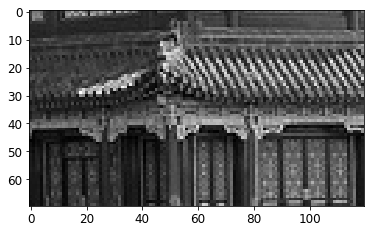

In [9]:
plot_image(image_grayscale)

A layer full of neurons using the same **filter** produces a **feature map** which highlights the areas in an image that are most similar to te filter.

Below are two popular filters: vertical filter and horizontal filter.

In [10]:
fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0 ,1] = 1

[[ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.]]


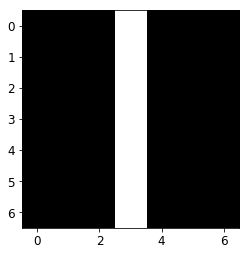

In [11]:
print(fmap[:, :, 0, 0])
plot_image(fmap[:, :, 0, 0])

[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.]]


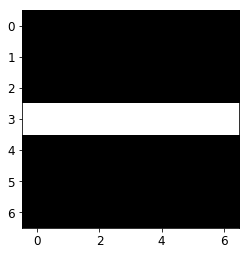

In [12]:
print(fmap[:, :, 0, 1])
plot_image(fmap[:, :, 0, 1])

https://www.tensorflow.org/api_docs/python/tf/nn/conv2d
https://www.tensorflow.org/api_guides/python/nn#Convolution

In [13]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME")

In [14]:
with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

Original image:


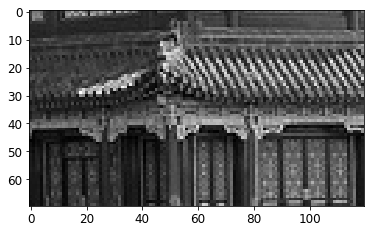

In [15]:
print("Original image:")
plot_image(images[0, :, :, 0])
plt.show()

Vertical edges detector:


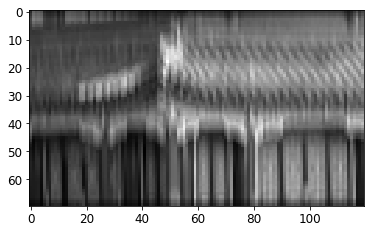

In [16]:
print("Vertical edges detector:")
plot_image(output[0, :, :, 0])

Horizontal edges detector:


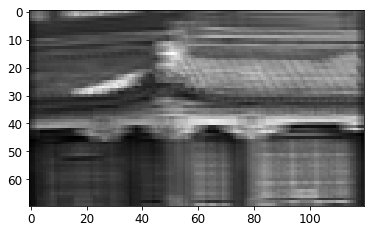

In [17]:
print("Horizontal edges detector:")
plot_image(output[0, :, :, 1])

## `tf.nn.conv2d`

In [18]:
# Load sample images
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

In [19]:
print("Mini-batch Size:{}  Height:{}  Width:{}  Channels:{}"
      .format(batch_size, height, width, channels))

Mini-batch Size:2  Height:427  Width:640  Channels:3


In [20]:
# Create vertical and horizontal filters with size of (7 x 7)
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # Vertical line
filters[3, :, :, 1] = 1 # Horizontal line

X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})

In TensorFlow, specifically `tf.nn.conv2d()` function, `strides` is a 1D array with four elements where two central elements are vertical and horizontal strides ($s_h$ and $s_w$). The first and the last elements must be 1. They can be used to specify a batch stride (skip instances) and channel stride (skip previous layer's feature maps or channels).

There are two types of padding: **VALID** and **SAME**:
- **VALID**: the convolutional layer does NOT use **zero padding**. As a result, some rows and columns at the bottom and right of the input image will be ignored.
- **SAME**: the convolutional layer use **zero padding**. In this case, the number of output neurons is equal to the number of input neurons divided by the stride, rounded up. Then zeros are added around the inputs.

When using `tf.nn.conv2d()`, we created the filters manually. When building real CNN, it's better to let the training algorithm to discover filers automatically. In order to accomplish that in TensorFlow, we'll use `tf.layers.conv2d()`. This function automatically creates *filters* variable for us (named *kernel* in graph). It also creates *bias* variable (named *bias* in graph)

However, convolutional layers have quite a few hyperparameters: the number of filters and their height and width, the strides, padding type. We, of course, can use cross-validation or grid search to find the right set of hyperparameters, but it would be time-consuming for large CNN. In practice, it's better to use **transfer learning** in order to reuse parts of the most successful network architecture.

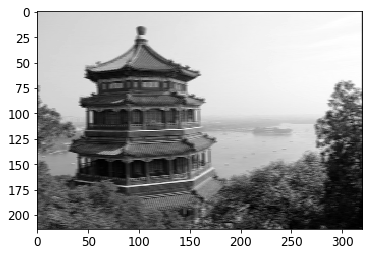

In [21]:
plt.imshow(output[0, :, :, 1], cmap="gray")

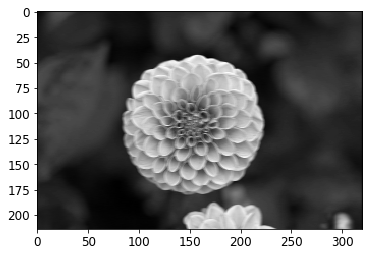

In [22]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plot_image(output[image_index, :, :, feature_map_index])

## `tf.layers.conv2d`

In [23]:
reset_graph()

# https://www.tensorflow.org/api_docs/python/tf/layers/conv2d
X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})

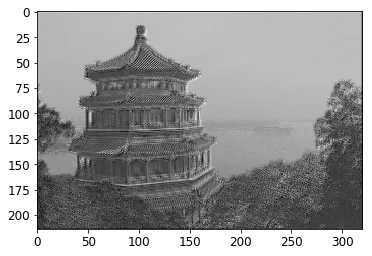

In [24]:
plt.imshow(output[0, :, :, 1], cmap="gray")

## `VALID and SAME Padding`

```
tf.nn.conv2d(
    input,
    filter,
    strides,
    padding,
    use_cudnn_on_gpu=True,
    data_format='NHWC',
    name=None
)
```

The above function compute a 2D convolution:
- **input**: 4D - [batch, input_height, input_width, input_channels]
- **filter**: 4D - [filter_height, filter_width, input_channels, output_channels]
- **strides**: 1D - length 4. strides[0] = strides[3] = 1

In [25]:
reset_graph()

filter_primes = np.array([2., 3., 5., 7., 11., 13.], dtype=np.float32)
filters = tf.constant(filter_primes.reshape(1, 6, 1, 1))
X = tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1, 1, 13, 1]))

In [26]:
valid_conv = tf.nn.conv2d(X, filters, strides=[1, 1, 5, 1], padding="VALID")
same_conv = tf.nn.conv2d(X, filters, strides=[1, 1, 5, 1], padding="SAME")

with tf.Session() as sess:
    print("X:")
    print(sess.run(X))
    print()
    print("FILTERS:")
    print(sess.run(filters))
    print()
    print("VALID:")
    print(valid_conv.eval())
    print()
    print("SAME:")
    print(same_conv.eval())
    print()

X:
[[[[  1.]
   [  2.]
   [  3.]
   [  4.]
   [  5.]
   [  6.]
   [  7.]
   [  8.]
   [  9.]
   [ 10.]
   [ 11.]
   [ 12.]
   [ 13.]]]]

FILTERS:
[[[[  2.]]

  [[  3.]]

  [[  5.]]

  [[  7.]]

  [[ 11.]]

  [[ 13.]]]]

VALID:
[[[[ 184.]
   [ 389.]]]]

SAME:
[[[[ 143.]
   [ 348.]
   [ 204.]]]]



In [27]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))

VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


Convolutional layers in CNNs require a huge amount of RAM, especially during training process, because the reverse pass of backpropagation requires all the intermediate values computed during forward pass.

During inference (making predictions) the RAM occupied by one layer can be released as soon as the next layer has been computed. As the result, the amount of RAM required is what needed between two consecutive layers.